# Football Events and Game Information

# Question to answer
What is the value of a shot? Or what is the probability of a shot being a goal given its location, shooter, league, assist method, gamestate, number of players on the pitch, time - known as expected goals (xG) models [Binary classification, Sara ]


imports and initialization

In [1]:
import zipfile
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=(5,5))

# Reading the Data

In [3]:
def read_merge():
    df_events = pd.read_csv("../events.csv")
    df_game_info = pd.read_csv("../ginf.csv")
    
    # manually convert the dictionary.txt to python dicts
    event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
    event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
    sides = {1:'Home', 2:'Away'}
    shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
    shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
    locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
    bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
    assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
    situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}
    
    # Mapping the dicts into the events dataframe
    df_events['event_type'] =   df_events['event_type'].map(event_types)
    df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
    df_events['side'] =         df_events['side'].map(sides)
    df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
    df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
    df_events['location'] =     df_events['location'].map(locations)
    df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
    df_events['assist_method']= df_events['assist_method'].map(assist_methods)
    df_events['situation'] =    df_events['situation'].map(situations)

    ## Naming the leagues with their popular names, which will make thinks much clear for us
    leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
              'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

    ## Map them to events
    df_game_info.league = df_game_info.league.map(leagues)

    # Merge into one table (merge other dataset to have country, league, date and season)
    df_events = df_events.merge(df_game_info ,how = 'left')
    
    return df_events

In [4]:
def fill_unk(df):
    '''
    Fill the following categorical features in df with 'UNK':
    shot_place, player, shot_outcome, bodypart, location and assist_method
    '''
    # Fill the required features with new class 'unknown'
    df.shot_place.fillna('UNK'   ,inplace = True)
    df.player.fillna('UNK'       ,inplace = True)
    df.shot_outcome.fillna('UNK' ,inplace = True)
    df.bodypart.fillna('UNK'     ,inplace = True)
    df.location.fillna('UNK'     ,inplace = True)
    df.assist_method.fillna('UNK',inplace = True)
    df.situation.fillna('UNK'    ,inplace = True)
    df.location.replace('Not recorded', 'UNK', inplace= True)

In [5]:
def fix_dtypes(df, cats):
    '''
    fixes the category datatypes for cats features
    '''
    # Notice that a lot of the floats and ints are in fact categoricals
    # We can fix this with Pandas' astype function
    d = dict.fromkeys(cats,'category')
    df = df.astype(d)
    df['is_goal'] = df['is_goal'].astype('bool') # this is a bool
    df['fast_break'] = df['fast_break'].astype('bool')
    
    df.odd_a = df.odd_a.astype('float16')
    df.odd_d = df.odd_d.astype('float16')
    df.odd_h = df.odd_h.astype('float16')
    df.odd_over  = df.odd_over.astype('float16')
    df.odd_under = df.odd_under.astype('float16')               
    df.odd_bts   = df.odd_bts.astype('float16')
    df.odd_bts_n = df.odd_bts_n.astype('float16')

    df.ftag = df.ftag.astype('int8')
    df.fthg = df.fthg.astype('int8')
    df.time = df.time.astype('int8')
    
    df.season =     df.season.astype('category')
    df.league =     df.league.astype('category')
    df.country =    df.country.astype('category')
    df.date = pd.to_datetime(df.date)
    return df

In [6]:
def missing_values_table(df):
    '''
    Function to calculate missing values by column# Funct 
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
def select_feats(df, feat_cols):
    '''
    Manually choose features (feat_cols) from a dataframe (df)
    '''
    return df[feat_cols]

# Cleaning Data

## Handling Missing Values: Fill categorical features with 'UNK'

By substituting any null value with a new class 'UNK' in the categorical columns.

In [38]:
# Read the data sets and merge them
df = read_merge()

In [42]:
df[df.location == 'Not recorded'].location.count()

1453

In [ ]:
df

In [9]:
df.dtypes

id_odsp           object
id_event          object
sort_order         int64
time               int64
text              object
event_type        object
event_type2       object
side              object
event_team        object
opponent          object
player            object
player2           object
player_in         object
player_out        object
shot_place        object
shot_outcome      object
is_goal            int64
location          object
bodypart          object
assist_method     object
situation         object
fast_break         int64
link_odsp         object
adv_stats           bool
date              object
league            object
season             int64
country           object
ht                object
at                object
fthg               int64
ftag               int64
odd_h            float64
odd_d            float64
odd_a            float64
odd_over         float64
odd_under        float64
odd_bts          float64
odd_bts_n        float64
dtype: object

In [10]:
# check the missing values in each feature
missing_values_table(df)

Your selected dataframe has 39 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
assist_method,773104,82.2
event_type2,726716,77.2
shot_place,713550,75.8
shot_outcome,712511,75.7


**We have large proportion of missing data values in important features as following**: <br>
`1` 82.2% missing in assist_method. <br>
`2` 75.8% missing in shot_place.  <br>
`3` 75.7% missing in shot_outcome. <br>
`4` 75.6% missing in situation. <br>
`5` 75.6% missing in bodypart. <br>
`6` 50.4% missing in location. <br>

In [172]:
df = read_merge()

# Fill the null values with a new category 'UNK' for 'Unknown'
fill_unk(df)

# Fix the datatypes of some categorical columns
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side', 'player']
df = fix_dtypes(df, categoricals)

In [173]:
# check the missing values in each feature
missing_values_table(df)

Your selected dataframe has 39 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
event_type2,726716,77.2
player2,649699,69.0


# Manual Feature Selection

In [174]:
feat_cols = ['odd_h', 'odd_d', 'odd_a', 
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'time', 'is_goal']

df_feats = select_feats(df, feat_cols)
df_feats['first_half'] = df_feats.time <= 45


In [50]:
# def first_half(row):
#     if row['time'] <= 45:
#         return 1
#     else:
#         return 0
    
# df_feats['first_half'] = df.apply(lambda row: first_half(row), axis=1)

In [175]:
df_feats.first_half = df_feats.first_half.astype('bool')
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 12 columns):
odd_h            941009 non-null float16
odd_d            941009 non-null float16
odd_a            941009 non-null float16
assist_method    941009 non-null category
location         941009 non-null category
side             941009 non-null category
shot_place       941009 non-null category
situation        941009 non-null category
bodypart         941009 non-null category
time             941009 non-null int8
is_goal          941009 non-null bool
first_half       941009 non-null bool
dtypes: bool(2), category(6), float16(3), int8(1)
memory usage: 20.6 MB


In [176]:
# Final chosen/engineered features
features = ['odd_h', 'odd_d', 'odd_a', 
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'first_half', 'is_goal']

In [ ]:
# # Duplicated rows indices
# df_indices = df_feats[df_feats.duplicated(keep=False)]
# df_indices = df_indices.groupby(df_indices.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()

# Explore the Data

We need to know how some features might affect 'is_goal'

In [178]:
# Find correlations with the is_goal 
correlations = df_feats.corr()['is_goal'].sort_values()
correlations

first_half   -0.003133
odd_h         0.003646
time          0.004524
odd_a         0.017853
odd_d         0.023307
is_goal       1.000000
Name: is_goal, dtype: float64

In [17]:
import seaborn as sns
%matplotlib inline 
#to plot the graphs inline on jupyter notebook

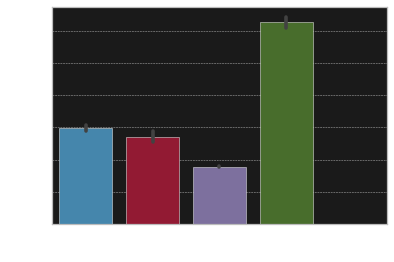

In [18]:
sns.barplot(df_feats.situation, df_feats.is_goal);

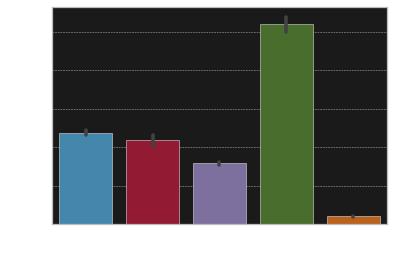

In [19]:
sns.barplot(df_feats.assist_method, df_feats.is_goal);

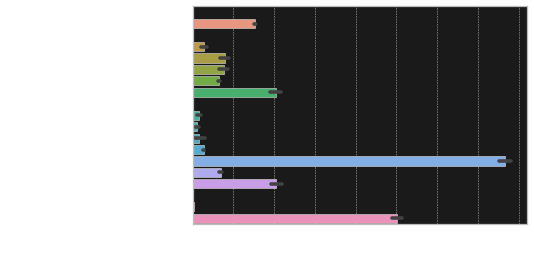

In [179]:
ax = sns.barplot(df_feats.is_goal , df_feats.location);
plt.xticks(rotation=90);

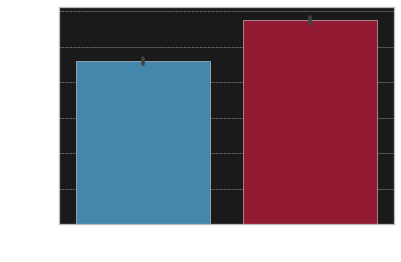

In [21]:
sns.barplot(df_feats.side, df_feats.is_goal);

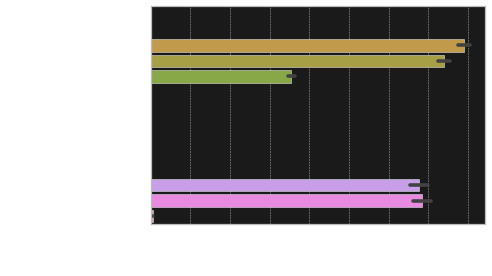

In [180]:
sns.barplot(df_feats.is_goal, df_feats.shot_place);
plt.xticks(rotation=90);

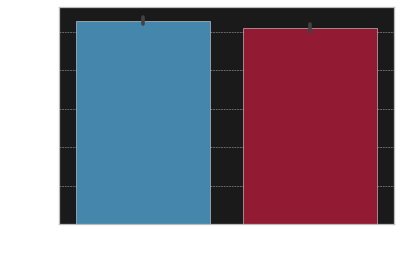

In [23]:
sns.barplot(df_feats.first_half, df_feats.is_goal);

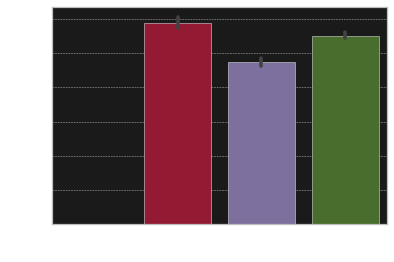

In [63]:
sns.barplot(df_feats.bodypart, df_feats.is_goal);

In [64]:
df_feats.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')

,bodypart,is_goal,Count
0,left foot,False,64532
1,UNK,False,711823
2,right foot,False,108488
3,left foot,True,6758
4,head,False,31720
5,right foot,True,13451
6,head,True,4236
7,UNK,True,1


## Train-Test Split

In [181]:
from sklearn.model_selection import train_test_split

In [182]:
training_features = df_feats.drop(columns=['is_goal', 'time'])
training_target = df_feats.is_goal

In [183]:
training_features.head()

,odd_h,odd_d,odd_a,assist_method,location,side,shot_place,situation,bodypart,first_half
0,1.55957,4.410156,7.421875,Pass,Left side of the box,Away,High and wide,Open play,left foot,True
1,1.55957,4.410156,7.421875,UNK,UNK,Home,UNK,UNK,UNK,True
2,1.55957,4.410156,7.421875,UNK,UNK,Home,UNK,UNK,UNK,True
3,1.55957,4.410156,7.421875,UNK,UNK,Home,UNK,UNK,UNK,True
4,1.55957,4.410156,7.421875,UNK,Defensive half,Away,UNK,UNK,UNK,True


In [184]:
side_map = {'Home': True, 'Away': False}
training_features.side.replace(side_map, inplace=True)

In [185]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 10 columns):
odd_h            941009 non-null float16
odd_d            941009 non-null float16
odd_a            941009 non-null float16
assist_method    941009 non-null category
location         941009 non-null category
side             941009 non-null bool
shot_place       941009 non-null category
situation        941009 non-null category
bodypart         941009 non-null category
first_half       941009 non-null bool
dtypes: bool(2), category(5), float16(3)
memory usage: 58.8 MB


In [186]:
# One-hot encoding for categorical columns
df_feats_dumm = pd.get_dummies(training_features)

In [187]:
print('Number of featurs after one-hot encoding: ', len(df_feats_dumm.columns))

Number of featurs after one-hot encoding:  52


In [188]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [189]:
x_train.shape

(846908, 52)

In [190]:
x_val.shape

(94101, 52)

# Without handling class imbalance

In [191]:
training_features = df_feats.drop(columns=['is_goal', 'time'])
training_target = df_feats.is_goal

In [192]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [193]:
model = LogisticRegression()
model.fit(x_train, y_train)

# make predictions
expected = y_val
predicted = model.predict(x_val)


# summarize the fit of the model
# print(metrics.classification_report(expected, predicted))
# print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

Accuracy:  0.9841659493522917
Balanced Acc:  0.8037608442451609


# Handling imbalance classes

we have class imbalance, we will use evaluation metrics different from accuracy which include (True positive, True negative, False positive, False negative)

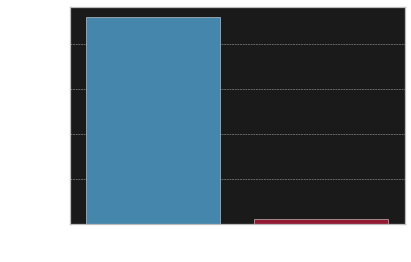

In [194]:
# distribution of the response variable
# plt.hist(df_feats.is_goal.astype('int'));
# plt.xticks(np.arange(0, 1.1, step=1))
sns.countplot(df_feats.is_goal)
# plt.bar(['Is goal', 'Not goal'], [df_feats.is_goal.sum(), len(df_feats)- df_feats.is_goal.sum()])

In [195]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [196]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 824932, True: 21976})


In [197]:
rus = RandomUnderSampler(random_state=42)
X_res_u, y_res_u = rus.fit_resample(x_train, y_train)

In [198]:
print('Resampled dataset shape %s' % Counter(y_res_u))

Resampled dataset shape Counter({False: 21976, True: 21976})


## Logistic Regression model

In [200]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res_u, y_res_u)

print(model)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.32      1.00      0.49      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.66      0.97      0.73     94101
weighted avg       0.98      0.95      0.96     94101

[[86463  5168]
 [    0  2470]]
Accuracy:  0.9450802860755996
Balanced Acc:  0.9717999367026443


In [119]:
# Find the residuals
pred = predicted.astype('int8')
y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]

In [105]:
from lime import lime_tabular

# Create a lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_res_u, 
                                                   mode = 'classification',
                                                   training_labels = y_res_u,
                                                   feature_names = df_feats_dumm.columns.tolist())

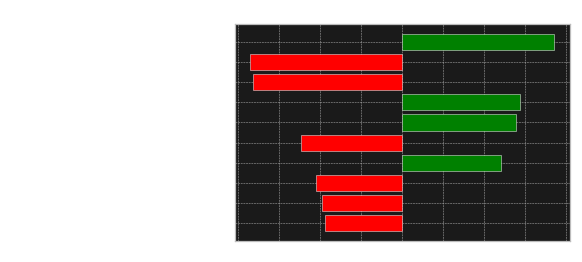

In [124]:
# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                     predict_fn = model.predict_proba, labels=(0,1))

# Plot the prediction explaination
exp.as_pyplot_figure(label=0);

# Gradient Boosting model

In [201]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(X_res_u, y_res_u)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.32      1.00      0.49      2470

   micro avg       0.94      0.94      0.94     94101
   macro avg       0.66      0.97      0.73     94101
weighted avg       0.98      0.94      0.96     94101

[[86439  5192]
 [    1  2469]]
Accuracy:  0.9448146140848662
Balanced Acc:  0.9714665475065742


# Support Vector Machine

In [202]:
from sklearn.svm import SVC

# Create the model
svm = SVC()

# Fit the model on the training data
svm.fit(X_res_u, y_res_u)

# Make predictions on the test data
predictions = svm.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.31      1.00      0.47      2470

   micro avg       0.94      0.94      0.94     94101
   macro avg       0.65      0.97      0.72     94101
weighted avg       0.98      0.94      0.96     94101

[[86012  5619]
 [    0  2470]]
Accuracy:  0.9402875633627698
Balanced Acc:  0.9693389791664393


## Random Forest

In [126]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

       False       1.00      0.95      0.97     91631
        True       0.35      0.99      0.52      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.68      0.97      0.75     94101
weighted avg       0.98      0.95      0.96     94101

[[87092  4539]
 [   21  2449]]
Accuracy:  0.951541428890235
Balanced Acc:  0.9709811691029551


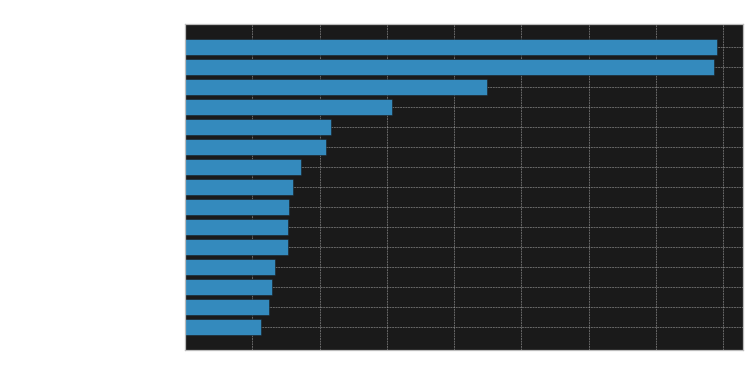

In [203]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res_u, y_res_u);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# 2nd Trial: SMOTENC and Remove null vals

Using the same manually chosen features

In [135]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 12 columns):
odd_h            941009 non-null float16
odd_d            941009 non-null float16
odd_a            941009 non-null float16
assist_method    941009 non-null category
location         941009 non-null category
side             941009 non-null category
shot_place       941009 non-null category
situation        941009 non-null category
bodypart         941009 non-null category
time             941009 non-null int8
is_goal          941009 non-null bool
first_half       941009 non-null bool
dtypes: bool(2), category(6), float16(3), int8(1)
memory usage: 60.6 MB


In [ ]:
# Drop NA values
df_feat = df_feats.copy()
df_feat.dropna(inplace=True)
df_feat.info()

In [ ]:
from imblearn.over_sampling import SMOTENC
from collections import Counter 

In [ ]:
print('Original dataset shape %s' % Counter(y_train))

In [ ]:
x_train.iloc[0,1]
num_feats = len(x_train.columns)
x_train.head()
cat_indices = np.arange(3, num_feats)
cat_indices

In [ ]:
# res_smote = SMOTENC(categorical_features= cat_indices, random_state=42)
# X_res, y_res = res_smote.fit_resample(x_train, y_train)

In [ ]:
# save SMOTE resampled dataset after removing the null values
df_X_smote = pd.DataFrame(X_res, columns=df_feats_dumm.columns)
df_y_smote = pd.DataFrame(y_res, columns=['is_goal'])
df_X_smote.to_csv('../X_res_SMOTE.csv')
df_y_smote.to_csv('../y_res_SMOTE.csv')

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

## Logistic Regression model

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res, y_res)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

## Random Forest

In [ ]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res, y_res);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# 3rd Trial: remove nulls and Random Over Sampling

In [ ]:
df_feats.dropna(inplace = True)
df_feats.info()

In [ ]:
training_features = df_feats.drop(columns=['is_goal'])
training_target = df_feats.is_goal

we have class imbalance, we will use evaluation metrics different from accuracy which include (True positive, True negative, False positive, False negative)

In [ ]:
# One-hot encoding for categorical columns
df_feats_dumm = pd.get_dummies(training_features)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [ ]:
x_train.shape

In [ ]:
x_val.shape

## Handling imbalance classes: Random Over Sampling

In [ ]:
# distribution of the response variable
df_feats.is_goal.astype('int').hist();

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
print('Original dataset shape %s' % Counter(y_train))

In [ ]:
rus = RandomOverSampler(random_state=42)
X_res_o, y_res_o = rus.fit_resample(x_train, y_train)

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res_o))

## Logistic Regression model

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res_o, y_res_o)

print(model)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

## Random Forest

In [ ]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res_o, y_res_o);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Trial #4 Filling null values with 'UNK' and using SMOTENC

In [136]:
from imblearn.over_sampling import SMOTENC
from collections import Counter 

In [137]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 824932, True: 21976})


In [142]:
x_train.iloc[0,1]
num_feats = len(x_train.columns)
x_train.head()
cat_indices = np.arange(3, num_feats)
cat_indices

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [143]:
# res_smote = SMOTENC(categorical_features= cat_indices, random_state=42)
# X_res, y_res = res_smote.fit_resample(x_train, y_train)

In [144]:
# save SMOTE resampled dataset after removing the null values
df_X_smote = pd.DataFrame(X_res, columns=df_feats_dumm.columns)
df_y_smote = pd.DataFrame(y_res, columns=['is_goal'])
df_X_smote.to_csv('../X_res_SMOTE_UNK.csv')
df_y_smote.to_csv('../y_res_SMOTE_UNK.csv')

In [145]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({False: 824932, True: 824932})


## Logistic Regression model

In [146]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res, y_res)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     91631
        True       0.34      0.99      0.51      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.67      0.97      0.74     94101
weighted avg       0.98      0.95      0.96     94101

[[86870  4761]
 [   21  2449]]
Accuracy:  0.9491822616125227
Balanced Acc:  0.9697697886749339


## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

       False       0.99      0.98      0.99     91631
        True       0.49      0.79      0.61      2470

   micro avg       0.97      0.97      0.97     94101
   macro avg       0.74      0.88      0.80     94101
weighted avg       0.98      0.97      0.98     94101

[[89600  2031]
 [  514  1956]]
Accuracy:  0.9729545913433438
Balanced Acc:  0.8848689230882341


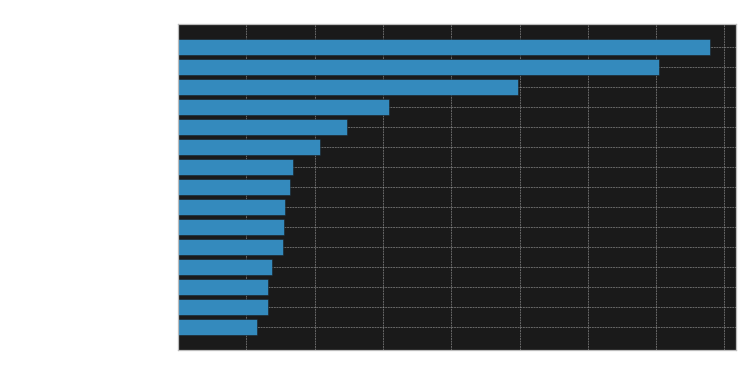

In [147]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res, y_res);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Trial #5: predicting the Null values

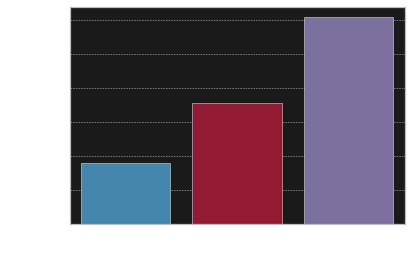

In [164]:
df = read_merge()
df = fix_dtypes(df, categoricals)


feats_fillNA = ['player', 'side', 'bodypart']

df_feats = select_feats(df, feats_fillNA)

df_feats.dropna(inplace=True)

sns.countplot(df_feats.bodypart);

# Train-test split
training_features = df_feats.drop(columns=['bodypart'])
training_target = df_feats.bodypart

In [165]:
# One-hot encoding for categorical columns
df_feats_fillNA = pd.get_dummies(training_features)

In [166]:
print('Number of featurs after one-hot encoding: ', len(df_feats_fillNA.columns))

Number of featurs after one-hot encoding:  6120


In [168]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_fillNA, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [169]:
x_train.shape

(206209, 6120)

In [170]:
x_val.shape

(22913, 6120)

In [171]:
model = LogisticRegression()
model.fit(x_train, y_train)

# make predictions
expected = y_val
predicted = model.predict(x_val)


# summarize the fit of the model
# print(metrics.classification_report(expected, predicted))
# print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

MemoryError: 

In [208]:
X_temp = X_res_u.copy()
y_temp = y_res_u.copy()
type(X_temp)

numpy.ndarray

In [210]:
X_temp.shape

(43952, 52)

In [211]:
y_temp.shape

(43952,)

In [213]:
both = np.hstack((X_temp, y_temp.reshape(-1,1)))
both.shape

(43952, 53)

In [215]:
feat_cols

['odd_h',
 'odd_d',
 'odd_a',
 'assist_method',
 'location',
 'side',
 'shot_place',
 'situation',
 'bodypart',
 'time',
 'is_goal']

In [217]:
X_temp = pd.DataFrame(data = X_temp, columns=df_feats_dumm.columns)

# 2 Odds



Odds are interpreted as the amount you will recieve back for every 1£ you bet on that result. For example, if the odds for a home win is 4, you will recieve 4£ for every 1£ you bet on a home win. Thus, from the perspective of the bookmaker, they would set a lower odd for the result they predict. The following function would return the bookmakers' predicted result of a match based on the highest odds for each result for a particular match.


In [220]:
df_game_info = pd.read_csv("../ginf.csv")

In [221]:
def odds_pred_result(odd_h,odd_d,odd_a):
    '''
    Predict game final result according to the odds for (home win, draw, and )
    Predict result of a match based on the highest odds for each result for a particular match
    '''
    if odd_h<odd_d and odd_h<odd_a:
        return("Home Win")
    elif odd_d<odd_h and odd_d<odd_a:
        return("Draw")
    elif odd_a<odd_d and odd_a<odd_h:
        return("Away Win")
    


# The next function would return the actual result of the match.
def actual_result(fthg,ftag):
    if fthg>ftag:
        return("Home Win")
    elif fthg==ftag:
        return("Draw")
    elif fthg<ftag:
        return("Away Win")
    
def actual_result_encode(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)

In [224]:
# We now compare the chances of us predicting the result of the game correctly just by looking at the odds.
def check_pred(data):
    correct=0
    wrong=0
    for i in range(1,data.shape[0]+1):
        odd_h=data[i-1:i]["odd_h"].item()
        odd_d=data[i-1:i]["odd_d"].item()
        odd_a=data[i-1:i]["odd_a"].item()
        fthg=data[i-1:i]["fthg"].item()
        ftag=data[i-1:i]["ftag"].item()
        oddsresult=odds_pred_result(odd_h,odd_d,odd_a)
        actresult=actual_result(fthg,ftag)
        if oddsresult==actresult:
            correct+=1
        else:
            wrong+=1
    return(str("%.2f"%(correct/(correct+wrong)))+str("% correct"))

check_pred(df_game_info)

'0.53% correct'

## We will try to use the odds and the difference among the odds to predict the result of a match.


In [242]:
x_odds = df_game_info.iloc[:,9:14]
x_odds.head()

result=[]
for i in range(1, df_game_info.shape[0]+1):
    result.append(actual_result_encode(df_game_info[i-1:i]["fthg"].item(),
                                       df_game_info[i-1:i]["ftag"].item()))
y_result = pd.DataFrame(result)

x_odds["diff_h_d"] = abs(x_odds["odd_h"] - x_odds["odd_d"])
x_odds["diff_d_a"] = abs(x_odds["odd_d"] - x_odds["odd_a"])
x_odds["diff_h_a"] = abs(x_odds["odd_h"] - x_odds["odd_a"])
x_odds = x_odds.drop(["fthg","ftag"],axis=1)

x_odds.tail()
y_result.tail()

,0
10107,2
10108,1
10109,1
10110,2
10111,1


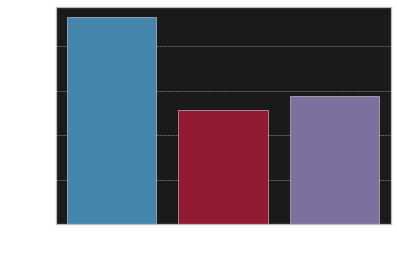

In [254]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

sns.countplot(y_result.iloc[:,0]);

In [255]:
x_odds_train, x_odds_test, y_odds_train, y_odds_test = train_test_split(x_odds, y_result, test_size=0.2,random_state=0)

# Logistic regression

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_odds_train, y_odds_train)

# make predictions
expected = y_odds_test
predicted = model.predict(x_odds_test)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

              precision    recall  f1-score   support

           1       0.54      0.89      0.67       925
           2       0.00      0.00      0.00       519
           3       0.56      0.50      0.53       579

   micro avg       0.55      0.55      0.55      2023
   macro avg       0.37      0.46      0.40      2023
weighted avg       0.41      0.55      0.46      2023

[[820   0 105]
 [396   0 123]
 [289   0 290]]
Accuracy:  0.5486900642609985
Balanced Acc:  0.462450014781621
